In [5]:
# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import string
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from sklearn.calibration import CalibratedClassifierCV
import joblib
from scipy.sparse import hstack

In [6]:
# ----- LOAD DATASETS --------
# LIAR dataset
df_liar_train = pd.read_csv("../data/datasets/LIARFakeNewsDataset/raw/train.tsv", sep="\t", header=None)
df_liar_valid = pd.read_csv("../data/datasets/LIARFakeNewsDataset/raw/valid.tsv", sep="\t", header=None)
df_liar_test = pd.read_csv("../data/datasets/LIARFakeNewsDataset/raw/test.tsv", sep="\t", header=None)
# ISOT dataset
df_isot_fake = pd.read_csv("../data/datasets/ISOT_FakeNewsDataset/News_Dataset/raw/Fake.csv")
df_isot_true = pd.read_csv("../data/datasets/ISOT_FakeNewsDataset/News_Dataset/raw/True.csv")
# FakeNewsNet dataset
df_fakenewsnet_buzzfeed_fake = pd.read_csv("../data/datasets/FakeNewsNet/raw/BuzzFeed_fake_news_content.csv")
df_fakenewsnet_buzzfeed_true = pd.read_csv("../data/datasets/FakeNewsNet/raw/BuzzFeed_real_news_content.csv")
df_fakenewsnet_politifact_fake = pd.read_csv("../data/datasets/FakeNewsNet/raw/PolitiFact_fake_news_content.csv")
df_fakenewsnet_politifact_true = pd.read_csv("../data/datasets/FakeNewsNet/raw/PolitiFact_real_news_content.csv")

In [7]:
# Output columns without headings or labels
df_liar_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [8]:
# Add column names to the dataset
df_liar_train.columns = ["ID", "label", "statement", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"]
df_liar_valid.columns = ["ID", "label", "statement", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"]
df_liar_test.columns = ["ID", "label", "statement", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"]

# Dataset with column headings
df_liar_train.head()

,ID,label,statement,subjects,speaker,speaker_job,state,party,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [9]:
# Remove unneeded columns keeping only label, statement columns
df_liar_train.drop(["ID", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"], axis=1, inplace=True)
df_liar_valid.drop(["ID", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"], axis=1, inplace=True)
df_liar_test.drop(["ID", "subjects", "speaker", "speaker_job", "state", "party", 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', "venue"], axis=1, inplace=True)

# Combine all 3 sets into one coherent corpus
df_liar_combined = pd.concat([df_liar_train,df_liar_valid, df_liar_test],axis=0).sample(frac = 1, random_state = 42).reset_index(drop = True)

# We'll need our ensemble to produce a real(true) or fake(false) classification.
liar_df_label_mapping = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 0,
    'barely-true': 0,
    'false': 0,
    'pants-fire': 0
}
df_liar_filtered = df_liar_combined[df_liar_combined['label'].isin(liar_df_label_mapping.keys())]

# Replace text labels with numerical ones
df_liar_filtered['label'] = df_liar_filtered['label'].str.lower().map(liar_df_label_mapping)

# Add column for dataset name to know which dataset this came from
df_liar_filtered["source_df"] = "liar"

df_liar_filtered.sample(5)

,label,statement,source_df
2699,0,The IRS is going to be in charge of a huge nat...,liar
835,0,Says large majority of Republicans believe Oba...,liar
7844,0,We have the fewest people employed in this cou...,liar
4063,0,Says Indiana Gov. Mike Pence denies that there...,liar
10949,1,Contends that President Obama literally said (...,liar


In [10]:
# LIAR dataset cleaning
print("LIAR Duplicate records: ", df_liar_filtered.duplicated().sum())
print("LIAR Null Values: \n", df_liar_filtered.isnull().sum())

LIAR Duplicate records:  23
LIAR Null Values: 
 label        0
statement    0
source_df    0
dtype: int64


In [11]:
# Clean null values & duplicate records
df_liar_filtered = df_liar_filtered.drop_duplicates()
df_liar_filtered.reset_index(drop=True, inplace=True)

print("LIAR shape: ", df_liar_filtered.shape)
print("LIAR Duplicates count:", df_liar_filtered.duplicated().sum())
print("LIAR Null Values: \n", df_liar_filtered.isnull().sum())

LIAR shape:  (12768, 3)
LIAR Duplicates count: 0
LIAR Null Values: 
 label        0
statement    0
source_df    0
dtype: int64


C:\Users\ajana\AppData\Local\Temp\ipykernel_11292\4264267530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_liar_filtered, palette='viridis')


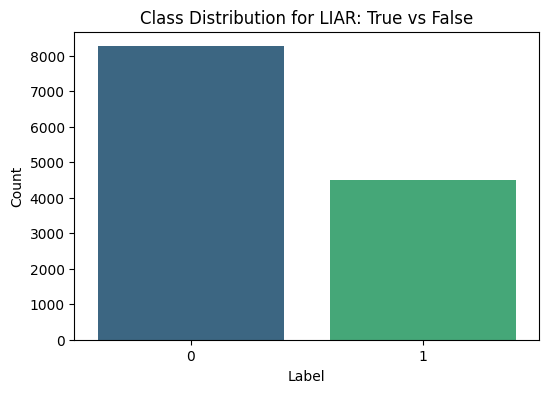

In [12]:
# Bar Chart visualization
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_liar_filtered, palette='viridis')
plt.title('Class Distribution for LIAR: True vs False')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
# What does the dataset look like?
df_isot_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
# Create labels for the ISOT datasets
df_isot_fake["label"] = 0
df_isot_true["label"] = 1
df_isot_combined = pd.concat([df_isot_fake,df_isot_true],axis=0).sample(frac = 1, random_state = 42).reset_index(drop = True)

# Remove date and subject columns
df_isot_combined.drop(["date", "subject"], axis=1, inplace=True)

# Check for null values  and duplicates
print("ISOT Duplicates count:", df_isot_combined.duplicated().sum())
print("ISOT Null Values: \n", df_isot_combined.isnull().sum())

ISOT Duplicates count: 5793
ISOT Null Values: 
 title    0
text     0
label    0
dtype: int64


In [15]:
# Clean duplicate records
df_isot_filtered = df_isot_combined.drop_duplicates()
df_isot_filtered.reset_index(drop=True, inplace=True)

# Create new 'statement' column
df_isot_filtered = df_isot_filtered.copy()
df_isot_filtered["statement"] = df_isot_filtered["title"] + " " + df_isot_filtered["text"]

# Remove title and text columns, keep only label and statement columns
df_isot_filtered.drop(["title", "text"], axis=1, inplace=True)

# Add column for dataset name to know which dataset this came from
df_isot_filtered["source_df"] = "isot"

print("ISOT Shape: ", df_isot_filtered.shape)
print("ISOT Duplicates count:", df_isot_filtered.duplicated().sum())
print("ISOT Null Values: \n", df_isot_filtered.isnull().sum())

ISOT Shape:  (39105, 3)
ISOT Duplicates count: 0
ISOT Null Values: 
 label        0
statement    0
source_df    0
dtype: int64


C:\Users\ajana\AppData\Local\Temp\ipykernel_11292\2288497807.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_isot_filtered, palette='viridis')


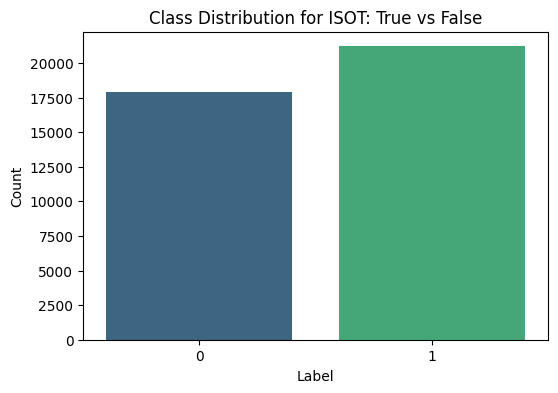

In [16]:
# Bar Chart visualization
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_isot_filtered, palette='viridis')
plt.title('Class Distribution for ISOT: True vs False')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [17]:
# What do the indivivual datasets look like?
df_fakenewsnet_buzzfeed_fake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ..."
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis..."
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi..."
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ..."
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty..."


In [18]:
# remove unneeded columns
df_fakenewsnet_buzzfeed_fake.drop(["id", "url", "top_img", "authors", "source", "publish_date", "movies", "images", "canonical_link", "meta_data"], axis=1, inplace=True)
df_fakenewsnet_buzzfeed_true.drop(["id", "url", "top_img", "authors", "source", "publish_date", "movies", "images", "canonical_link", "meta_data"], axis=1, inplace=True)
df_fakenewsnet_politifact_fake.drop(["id", "url", "top_img", "authors", "source", "publish_date", "movies", "images", "canonical_link", "meta_data"], axis=1, inplace=True)
df_fakenewsnet_politifact_true.drop(["id", "url", "top_img", "authors", "source", "publish_date", "movies", "images", "canonical_link", "meta_data"], axis=1, inplace=True)

# Create new 'label' column
df_fakenewsnet_buzzfeed_fake["label"] = 0
df_fakenewsnet_buzzfeed_true["label"] = 1
df_fakenewsnet_politifact_fake["label"] = 0
df_fakenewsnet_politifact_true["label"] = 1

# Create new 'statement' column
df_fakenewsnet_buzzfeed_fake["statement"] = df_fakenewsnet_buzzfeed_fake["title"] + " " + df_fakenewsnet_buzzfeed_fake["text"]
df_fakenewsnet_buzzfeed_true["statement"] = df_fakenewsnet_buzzfeed_true["title"] + " " + df_fakenewsnet_buzzfeed_true["text"]
df_fakenewsnet_politifact_fake["statement"] = df_fakenewsnet_politifact_fake["title"] + " " + df_fakenewsnet_politifact_fake["text"]
df_fakenewsnet_politifact_true["statement"] = df_fakenewsnet_politifact_true["title"] + " " + df_fakenewsnet_politifact_true["text"]

# Combine the modified datasets
df_fakenewsnet_combined = pd.concat([df_fakenewsnet_buzzfeed_fake,df_fakenewsnet_buzzfeed_true, df_fakenewsnet_politifact_fake, df_fakenewsnet_politifact_true],axis=0).sample(frac = 1, random_state = 42).reset_index(drop = True)

# remove title and text column from combined dataset
df_fakenewsnet_combined.drop(["title", "text"], axis=1, inplace=True)

df_fakenewsnet_combined.sample(5)

,label,statement
96,0,Australia Voted To Ban Muslims And Liberals Ar...
415,0,"“If You Can’t Run Your Own House, You Certainl..."
112,1,Rouhani: Iran deal able to weather the electio...
109,0,Clinton demands Charlotte police video release...
259,1,Clinton: ‘The next 50 days will determine the ...


In [19]:
# Check for null values  and duplicates
print("FakeNewsNet Duplicates count:", df_fakenewsnet_combined.duplicated().sum())
print("FakeNewsNet Null Values: \n", df_fakenewsnet_combined.isnull().sum())

FakeNewsNet Duplicates count: 19
FakeNewsNet Null Values: 
 label        0
statement    0
dtype: int64


In [20]:
# Clean duplicate records
df_fakenewsnet_filtered = df_fakenewsnet_combined.drop_duplicates()
df_fakenewsnet_filtered.reset_index(drop=True, inplace=True)

# Add column for dataset name to know which dataset this came from
df_fakenewsnet_filtered["source_df"] = "fakenewsnet"

print("FakeNewsNet Shape: ", df_fakenewsnet_filtered.shape)
print("FakeNewsNet Duplicates count:", df_fakenewsnet_filtered.duplicated().sum())
print("FakeNewsNet Null Values: \n", df_fakenewsnet_filtered.isnull().sum())

FakeNewsNet Shape:  (403, 3)
FakeNewsNet Duplicates count: 0
FakeNewsNet Null Values: 
 label        0
statement    0
source_df    0
dtype: int64


C:\Users\ajana\AppData\Local\Temp\ipykernel_11292\3233772363.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fakenewsnet_filtered["source_df"] = "fakenewsnet"


C:\Users\ajana\AppData\Local\Temp\ipykernel_11292\708868795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_fakenewsnet_combined, palette='viridis')


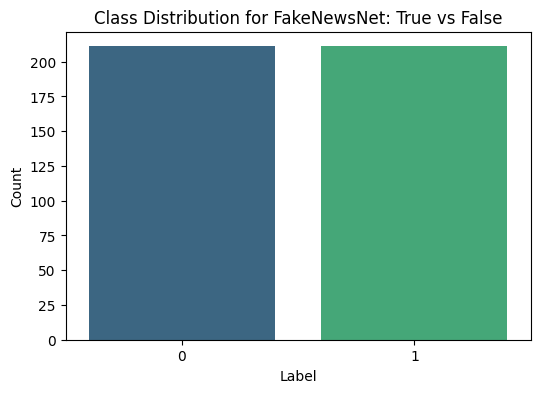

In [21]:
# Bar Chart visualization
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_fakenewsnet_combined, palette='viridis')
plt.title('Class Distribution for FakeNewsNet: True vs False')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [22]:
# Combine all 3 datasets into one
df_total_combined = pd.concat([df_liar_filtered,df_isot_filtered, df_fakenewsnet_filtered],axis=0).sample(frac = 1, random_state = 42).reset_index(drop = True)

df_total_combined.shape

(52276, 3)

C:\Users\ajana\AppData\Local\Temp\ipykernel_11292\73108324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_total_combined, palette='viridis')


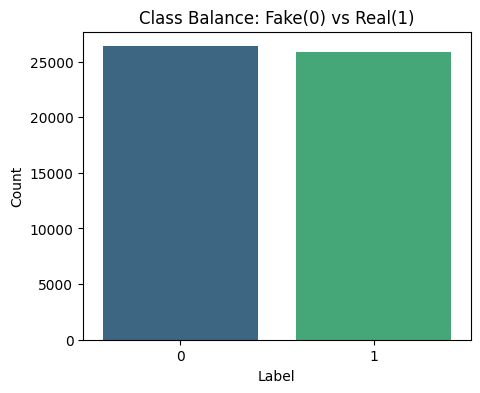

In [23]:
# Class Balanace visualization
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df_total_combined, palette='viridis')
plt.title('Class Balance: Fake(0) vs Real(1)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

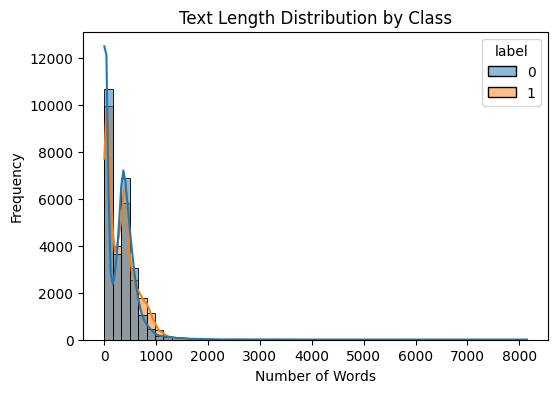

In [24]:
df_total_combined['text_length'] = df_total_combined['statement'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(data=df_total_combined, x='text_length', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [25]:
def get_top_words(df, label, n=10):
    words = " ".join(df[df['label']==label]['statement']).lower().split()
    return Counter(words).most_common(n)

print("Top words in Real News:", get_top_words(df_total_combined, 1))
print("Top words in Fake News:", get_top_words(df_total_combined, 0))

Top words in Real News: [('the', 483561), ('to', 254367), ('of', 210510), ('a', 199294), ('in', 186721), ('and', 183457), ('on', 111331), ('that', 86523), ('for', 82950), ('said', 71707)]
Top words in Fake News: [('the', 400815), ('to', 230742), ('of', 181063), ('and', 172234), ('a', 164774), ('in', 127554), ('that', 116203), ('s', 98236), ('is', 88040), ('for', 74188)]


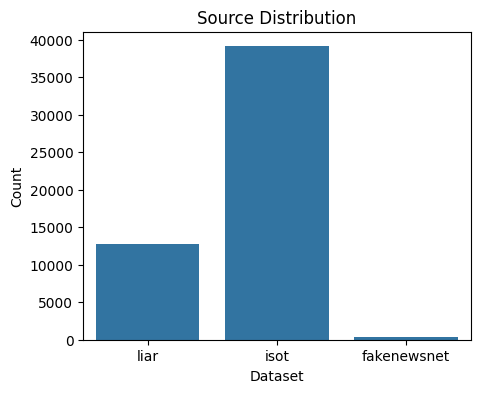

In [26]:
plt.figure(figsize=(5,4))
sns.countplot(x='source_df', data=df_total_combined)  # Assuming you kept a "source" column
plt.title("Source Distribution")
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.show()


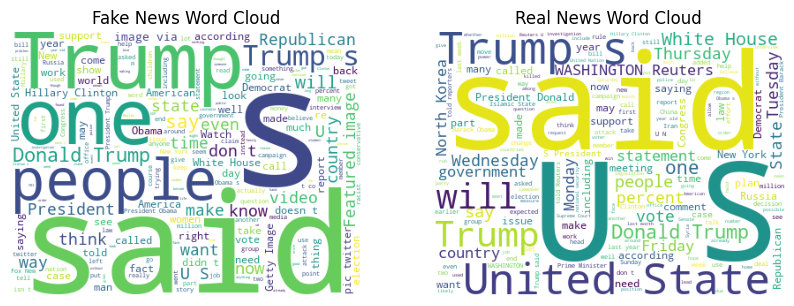

In [27]:
fake_text = " ".join(df_total_combined[df_total_combined['label']==0]['statement'])
real_text = " ".join(df_total_combined[df_total_combined['label']==1]['statement'])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(fake_text))
plt.title("Fake News Word Cloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(real_text))
plt.title("Real News Word Cloud")
plt.axis('off')

plt.show()

In [28]:
stop_words = set(stopwords.words('english'))

# 1. Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove digits
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning
df_total_combined['clean_text'] = df_total_combined['statement'].apply(clean_text)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_total_combined['clean_text'], df_total_combined['label'], 
    test_size=0.2, stratify=df_total_combined['label'], random_state=42
)

# 3. TF-IDF Vectorization

# ==== Word-Level TF-IDF =====
word_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_word_tfidf = word_tfidf.fit_transform(X_train)
X_test_word_tfidf = word_tfidf.transform(X_test)

# ==== Character-Level TF-IDF =====
char_tfidf = TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(3,5))
X_train_char_tfidf = char_tfidf.fit_transform(X_train)
X_test_char_tfidf = char_tfidf.transform(X_test)

# ==== Combine TF-IDFs =====
X_train_combined = hstack([X_train_word_tfidf, X_train_char_tfidf])
X_test_combined = hstack([X_test_word_tfidf, X_test_char_tfidf])

print("Word-level TF-IDF shape:", X_train_word_tfidf.shape)
print("Char-level TF-IDF shape:", X_train_char_tfidf.shape)
print("Combined feature shape:", X_train_combined.shape)

# Cross-validation setup: 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Word-level TF-IDF shape: (41820, 5000)
Char-level TF-IDF shape: (41820, 5000)
Combined feature shape: (41820, 10000)


In [29]:
# Load a pre-trained sentence embedding model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for all news statements
X_embeddings = sentence_model.encode(df_total_combined['statement'], show_progress_bar=True)
y = df_total_combined['label'].values

Batches: 100%|██████████| 1634/1634 [1:35:00<00:00,  3.49s/it] 


In [30]:
# Reusable CrossValidation Function to train RF and LR baseline models
def evaluate_model_with_proba(model, X, y, n_splits=5, model_name=None, save_proba=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    acc_scores, prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], [], []
    all_y_true, all_y_pred, all_y_proba = [], [], []  # store predictions across folds

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1] #probabilities for class "1"
        
        acc_scores.append(accuracy_score(y_val, y_pred))
        prec_scores.append(precision_score(y_val, y_pred))
        rec_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        
        # collect confusion data
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
    
    results = {
        "Model": model_name or model.__class__.__name__,
        "Accuracy": np.mean(acc_scores),
        "Precision": np.mean(prec_scores),
        "Recall": np.mean(rec_scores),
        "F1": np.mean(f1_scores),
        "AUC": np.mean(auc_scores)
    }
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Precision: {np.mean(prec_scores):.4f}")
    print(f"Recall: {np.mean(rec_scores):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f}")
    print("-" * 40)
    
    # Compute and display confusion matrix across all folds
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: Baseline {model.__class__.__name__}")
    plt.show()
    
    # Save outputs for later ROC/AUC plotting or ensemble use
    if save_proba:
        np.savez_compressed(f"{results['Model']}_cv_results.npz",
                            y_true=np.array(all_y_true),
                            y_proba=np.array(all_y_proba),
                            metrics=results)
    
    return results, np.array(all_y_true), np.array(all_y_proba)
    

## Baseline LogisticRegression & RandomForest

Model: LogisticRegression
Accuracy: 0.8542
Precision: 0.8574
Recall: 0.8466
F1 Score: 0.8519
----------------------------------------


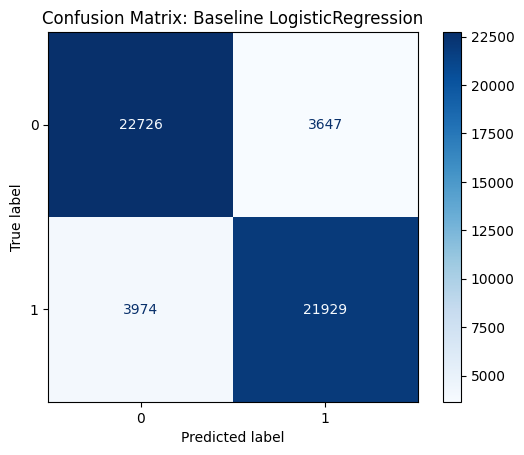

Model: RandomForestClassifier
Accuracy: 0.8373
Precision: 0.8758
Recall: 0.7827
F1 Score: 0.8266
----------------------------------------


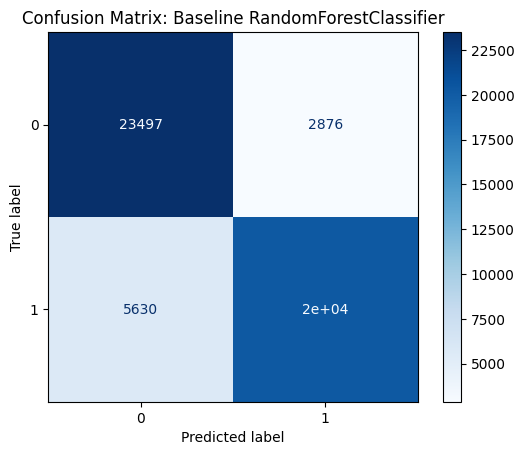

In [31]:
# Define models and run them through the function
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

lr_results, y_true_lr, y_proba_lr = evaluate_model_with_proba(lr_model, X_embeddings, y, 5, model_name="LogisticRegression")
rf_results, y_true_rf, y_proba_rf = evaluate_model_with_proba(rf_model, X_embeddings, y, 5, model_name="RandomForest")

SVM, unlike RF and LR, does not simply output probabilities with confidence scores. So, we'll wrap the model training and testing with CalibratedClassifierCV, training a calibration layer on top of SVM outputs to producw this probability-like score. It will still maintain its speed.

## Baseline SVM model


SVM_Linear Performance
Accuracy: 0.8602
Precision: 0.8640
Recall: 0.8521
F1 Score: 0.8580
AUC: 0.9390
----------------------------------------


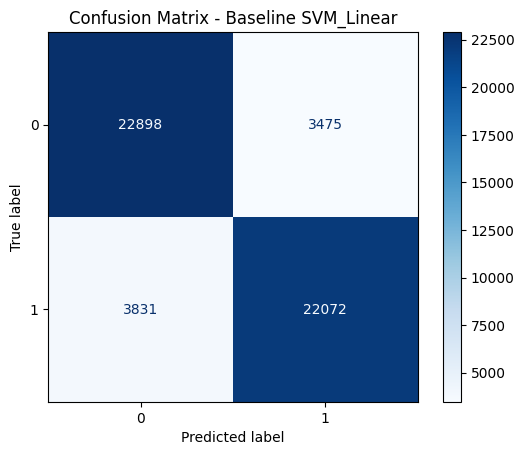

In [32]:
# Function to train an output SVM
def evaluate_svm_with_probs_cv(X, y, n_splits=5, model_name="SVM_Linear", save_proba=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    acc_scores, prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], [], []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        base_svm = LinearSVC(random_state=42)
        calibrated_svm = CalibratedClassifierCV(base_svm, cv=3)  # inner calibration folds
        
        calibrated_svm.fit(X_tr, y_tr)
        y_pred = calibrated_svm.predict(X_val)
        y_proba = calibrated_svm.predict_proba(X_val)[:, 1]
        
        # Metrics
        acc_scores.append(accuracy_score(y_val, y_pred))
        prec_scores.append(precision_score(y_val, y_pred))
        rec_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        
        # Store results
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
    
    # Mean performance
    results = {
        "Model": model_name,
        "Accuracy": np.mean(acc_scores),
        "Precision": np.mean(prec_scores),
        "Recall": np.mean(rec_scores),
        "F1": np.mean(f1_scores),
        "AUC": np.mean(auc_scores)
    }

    # Print performance
    print(f"\n{model_name} Performance")
    print(f"Accuracy: {results['Accuracy']:.4f}")
    print(f"Precision: {results['Precision']:.4f}")
    print(f"Recall: {results['Recall']:.4f}")
    print(f"F1 Score: {results['F1']:.4f}")
    print(f"AUC: {results['AUC']:.4f}")
    print("-" * 40)
    
    # Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Baseline {model_name}")
    plt.show()

    # Save for ROC/AUC plotting
    if save_proba:
        np.savez_compressed(f"{model_name}_cv_results.npz",
                            y_true=np.array(all_y_true),
                            y_proba=np.array(all_y_proba),
                            metrics=results)

    return results, np.array(all_y_true), np.array(all_y_proba)


# Use the function
svm_results, y_true_svm, y_proba_svm = evaluate_svm_with_probs_cv(X_embeddings, y)

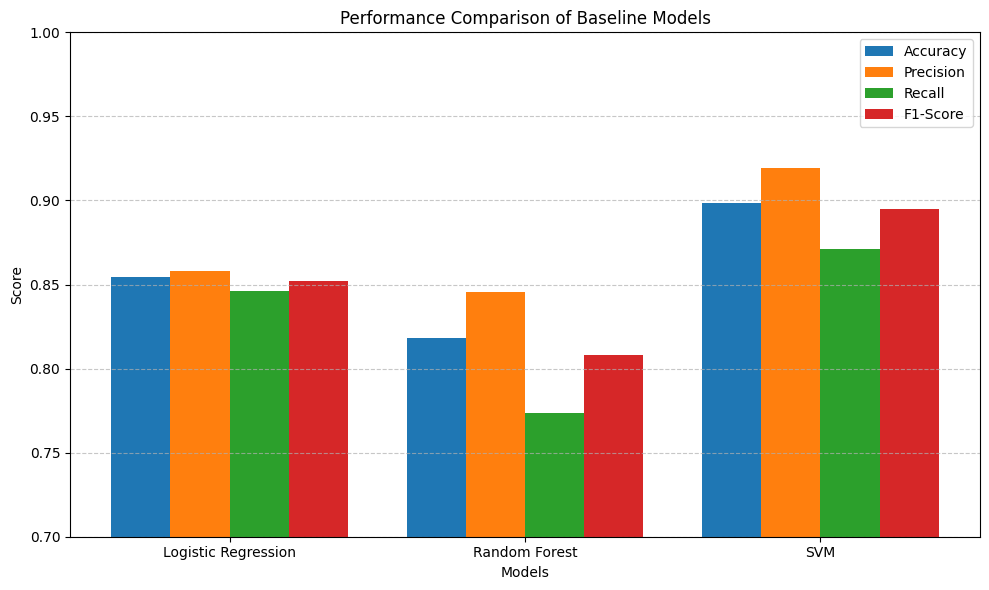

In [33]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracy = [0.8546, 0.8179, 0.8983]
precision = [0.8583, 0.8457, 0.9193]
recall = [0.8464, 0.7737, 0.8713]
f1 = [0.8523, 0.8081, 0.8947]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
plt.bar(x - 0.3, accuracy, width, label='Accuracy')
plt.bar(x - 0.1, precision, width, label='Precision')
plt.bar(x + 0.1, recall, width, label='Recall')
plt.bar(x + 0.3, f1, width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Comparison of Baseline Models')
plt.xticks(x, models)
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

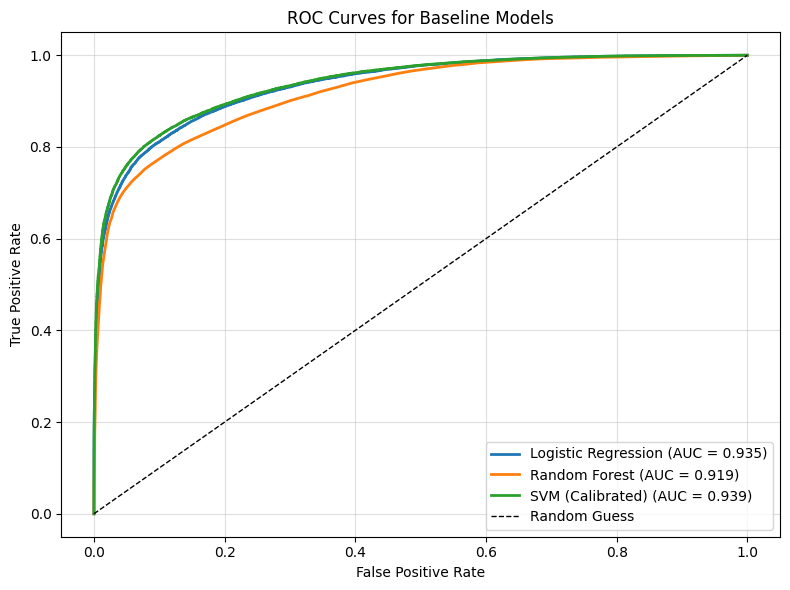

In [34]:
def plot_roc_from_memory(model_probs_dict):
    plt.figure(figsize=(8, 6))

    for model_name, (y_true, y_proba) in model_probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")

    # Add reference diagonal (random chance)
    plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random Guess")

    plt.title("ROC Curves for Baseline Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()



# Collect all results
model_probs = {
    "Logistic Regression": (y_true_lr, y_proba_lr),
    "Random Forest": (y_true_rf, y_proba_rf),
    "SVM (Calibrated)": (y_true_svm, y_proba_svm)
}

# Plot ROC/AUC
plot_roc_from_memory(model_probs)

# Building Truthguard via Stacking

TruthGuard will use a LogisticRegression meta-learner. This meta-learner takes in the predictions from alll 3 baseline models as inputs, and leanrs to give weights to each output, influencing the final prediction. <br />
Truthguard incorporates 5-fold Cross-Validation at each step, ensuring the meta-learner never sees the same data twice, preventing overfitting.

## Truthguard Training Pipeline

In [35]:
def truthguard_stackng_with_cv(base_models, meta_model, X_train, y_train, X_test, y_test, n_splits = 5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_meta = np.zeros((X_train.shape[0], len(base_models)))
    test_meta = np.zeros((X_test.shape[0], len(base_models)))
    test_meta_folds = np.zeros((n_splits, X_test.shape[0], len(base_models)))
    
    # Cross-Validation loop
    for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        for j, model in enumerate(base_models):
            model.fit(X_tr, y_tr)
            train_meta[val_idx, j] = model.predict_proba(X_val)[:, 1]
            test_meta_folds[i, :, j] = model.predict_proba(X_test)[:, 1]
    
    # Average test predictions across folds
    test_meta = test_meta_folds.mean(axis=0)
    
    # Train meta-learner on stacked features
    meta_model.fit(train_meta, y_train)
    
    # Final predictions on test set
    y_pred = meta_model.predict(test_meta)
    y_proba = meta_model.predict_proba(test_meta)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    
    print("=== TruthGuard (Stacked Ensemble) Performance ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("TruthGuard Confusion Matrix")
    plt.show()
    
    return meta_model, test_meta, y_pred, y_proba

## Baseline Model Hyperparameter Tuning

### LogisticRegression Tuning

In [36]:
# param_grid_lr = {
#     'C': [0.01, 0.1, 1, 10],
#     'penalty': ['l2'], # l1 iss slower with sparse data
#     'solver': ['liblinear', 'saga']
# }

# default_lr_model = LogisticRegression(max_iter=1000)

# grid_tuned_lr_model = RandomizedSearchCV(
#     default_lr_model,
#     param_distributions=param_grid_lr,
#     n_iter=5,
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# grid_tuned_lr_model.fit(X_train_combined, y_train)
# print("Best LR params: ", grid_tuned_lr_model.best_params_)

### RandomForest Tuning

In [37]:
# param_grid_rf = {
#     'n_estimators': [200, 500],
#     'max_depth': [20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# default_rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# grid_tuned_rf_model = RandomizedSearchCV(
#     default_rf_model,
#     param_distributions=param_grid_rf,
#     n_iter=5,
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# grid_tuned_rf_model.fit(X_train_combined, y_train)
# print("Best RF Params:", grid_tuned_rf_model.best_params_)

### SVM Tuning
Since SVM models are the slowest in our scope, we'll just tune the C parameter

In [38]:
# param_grid_svm = {
#     'C': [0.01, 0.1, 1, 10]
# }

# default_svm_model = LinearSVC(max_iter=5000)

# grid_tuned_svm_model = RandomizedSearchCV(
#     default_svm_model,
#     param_distributions=param_grid_svm,
#     n_iter=4,
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# grid_tuned_svm_model.fit(X_train_combined, y_train)
# print("Best SVM Params:", grid_tuned_svm_model.best_params_)

# # Wrap in CalibratedClassifier for probabilities
# tuned_svm_model = CalibratedClassifierCV(grid_tuned_svm_model.best_estimator_, cv=5)
# tuned_svm_model.fit(X_train_combined, y_train)

## Incorporate Tuned Baseline Models into Truthguard Pipeline

=== TruthGuard (Stacked Ensemble) Performance ===
Accuracy:  0.9054
Precision: 0.9385
Recall:    0.8659
F1 Score:  0.9007
AUC:       0.9752


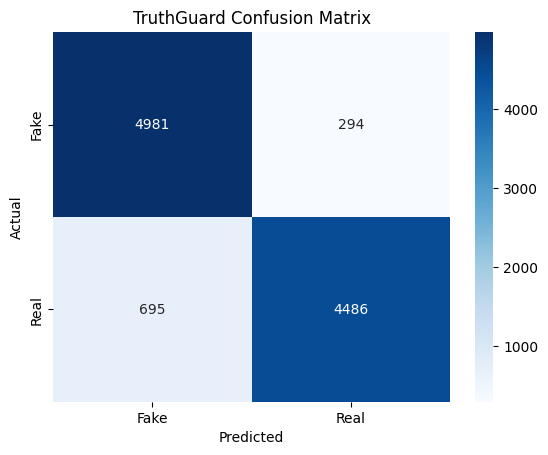

In [39]:
# Define the individual models
# tuned_lr_model = grid_tuned_lr_model.best_estimator_
# tuned_rf_model = grid_tuned_rf_model.best_estimator_

# Placeholder baseline models for use
lr_base_model = LogisticRegression(max_iter=1000)
rf_base_model = RandomForestClassifier(n_estimators=100)
svm_base_model = CalibratedClassifierCV(LinearSVC(), cv=5)

all_base_models = [lr_base_model, rf_base_model, svm_base_model]
meta_learner_model = LogisticRegression()

# all_base_models = [tuned_lr_model, tuned_rf_model, tuned_svm_model]
# meta_learner_model = grid_tuned_lr_model.best_estimator_

# Train Truthguard with CV and get final predictions on test set
truthguard_model, test_meta, final_preds, y_proba_truthguard = truthguard_stackng_with_cv(
    all_base_models,
    meta_learner_model,
    X_train_combined,
    y_train,
    X_test_combined,
    y_test,
    n_splits = 5
)

After getting the predictions and the model results, let's incorporate a save/load pipeline to save the hybrid model.

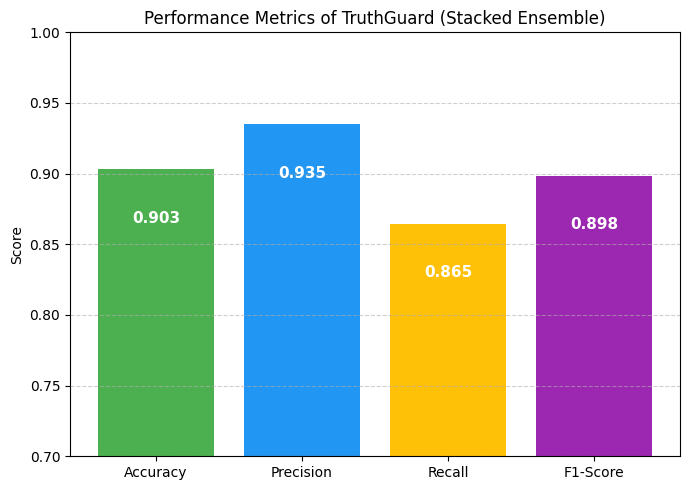

In [40]:
# TruthGuard performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [0.9032, 0.9351, 0.8647, 0.8985]

plt.figure(figsize=(7,5))
bars = plt.bar(metrics, scores, color=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0'])

# Annotate bars with values
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.04,
             f"{score:.3f}", ha='center', va='bottom', color='white', fontsize=11, fontweight='bold')

plt.title("Performance Metrics of TruthGuard (Stacked Ensemble)")
plt.ylim(0.7, 1.0)
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

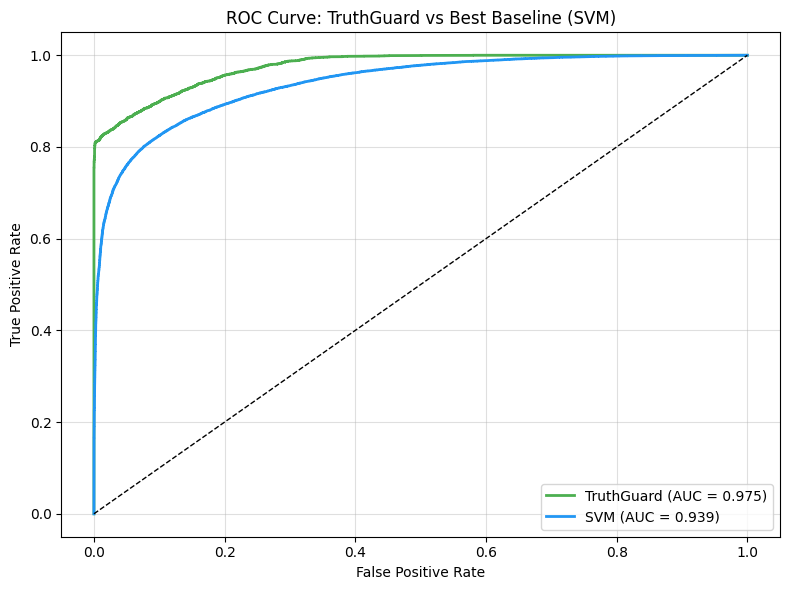

In [41]:
y_true_truthguard = y_test
fpr_tg, tpr_tg, _ = roc_curve(y_true_truthguard, y_proba_truthguard)
fpr_svm, tpr_svm, _ = roc_curve(y_true_svm, y_proba_svm)

auc_tg = auc(fpr_tg, tpr_tg)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_tg, tpr_tg, lw=2, label=f"TruthGuard (AUC = {auc_tg:.3f})", color="#4CAF50")
plt.plot(fpr_svm, tpr_svm, lw=2, label=f"SVM (AUC = {auc_svm:.3f})", color="#2196F3")

plt.plot([0,1],[0,1],"k--", lw=1)
plt.title("ROC Curve: TruthGuard vs Best Baseline (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

## Truthguard Model Save & Load Pipeline for Reusability

In [42]:
# with open("artifacts") as file:
#     joblib.dump()

In [43]:
# joblib.dump({
#     "word_vectorizer": word_tfidf,
#     "char_vectorizer": char_tfidf,
#     "base_models": all_base_models,
#     "meta_model": truthguard_model
# }, "truthguard_pipeline.pkl")

# print("Truthguard pipeline saved successfully!")